<a href="https://colab.research.google.com/github/blackdragonae/mcmc/blob/main/mcmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MCMC code**

In [1]:
!pip install zeus-mcmc
!pip install getdist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.0/826.0 kB 9.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for getdist: filename=getdist-1.4.8-py3-none-any.whl size=810431 sha256=0c2e3fd2e4cf6c03fbb7af9ae4980e13cc18dd443c581d96c23811a3fc7cb5a9
  Stored in directory: /root/.cache/pip/wheels/ba/db/c3/b71b37200117c3b4c68b8bb14c9e27ed36006205fa25ba0c40
Successfully built getdist


Importando librerias

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import os
import random
from astropy.table import Table
from astropy.cosmology import FlatwCDM
from getdist import plots, MCSamples
import zeus
from zeus import ChainManager
import numpy as np
import scipy.optimize as op
from multiprocessing import Pool

**Montecarlo Method to calcualte Pi**

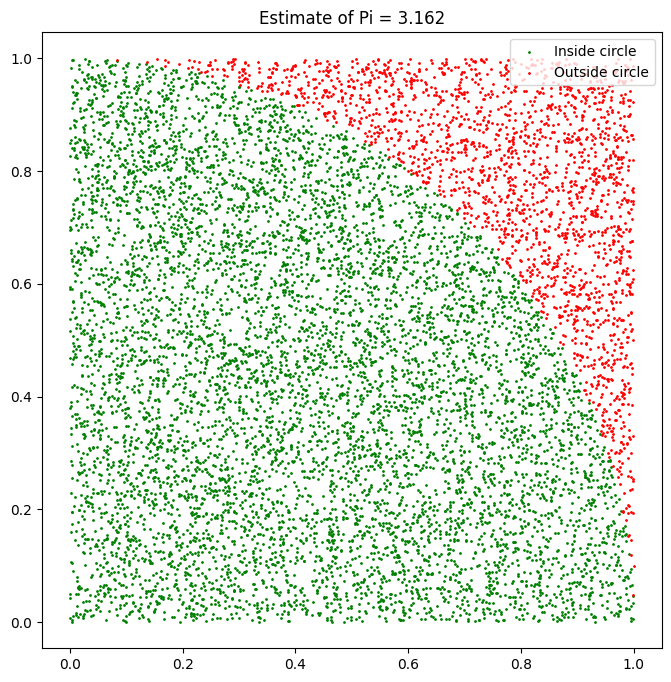

In [7]:
def estimate_pi(num_samples):
    inside_circle = 0
    inside_x = []
    inside_y = []
    outside_x = []
    outside_y = []

    for _ in range(num_samples):
        x, y = random.random(), random.random()
        if x**2 + y**2 <= 1:
            inside_circle += 1
            inside_x.append(x)
            inside_y.append(y)
        else:
            outside_x.append(x)
            outside_y.append(y)

    pi_estimate = 4 * inside_circle / num_samples
    return pi_estimate, inside_x, inside_y, outside_x, outside_y

# Number of samples
num_samples = 10000
pi_estimate, inside_x, inside_y, outside_x, outside_y = estimate_pi(num_samples)

# Plotting
%matplotlib inline
plt.figure(figsize=(8, 8))
plt.scatter(inside_x, inside_y, color='green', s=1, label='Inside circle')
plt.scatter(outside_x, outside_y, color='red', s=1, label='Outside circle')
plt.legend()
plt.axis('equal')
plt.title(f'Estimate of Pi = {pi_estimate}')
plt.show()

**Estimación de parametros cosmológico con Zeus**

In [8]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Función Log Likelihood

In [9]:
def lnlike(theta, x, y, z, xerr, yerr, zerr):
    alpha, beta, h0, Om = theta

    Or = 4.153e-5 * h0**(-2)
    w0 = -1.0

    cosmo = FlatwCDM(H0=h0*100, Om0=Om, w0=w0)
    #---------------------------------------------------------------------------
    ixG = np.where(z>10)
    ixH = np.where(z<10)

    Mum = z*0.0
    MumErr = z*0.0

    Mum[ixG] = z[ixG]
    MumErr[ixG] = zerr[ixG]

    Mum[ixH] = 5.0*np.log10(cosmo.luminosity_distance(z[ixH]).value) + 25.0
    MumErr[ixH] = (5.0/np.log(10.0))*(zerr[ixH]/z[ixH])

    Mu = 2.5*(beta*x + alpha) - 2.5*y - 100.195
    MuErr = 2.5*np.sqrt((yerr)**2 + beta**2*(xerr)**2)

    R = (Mu - Mum)
    W = 1.0/(MuErr**2 + MumErr**2)

    xsq = np.sum(R**2*W)
    llq = -0.5*xsq
    return (llq, xsq, R, Mum)

Definición de los priors

In [10]:
def lnprior(theta):
    alpha, beta, h0, Om = theta
    if (0.0 <= beta <= 10.0 and 20.0 <= alpha <= 40.0 and 0.5 <= h0 <= 1.0 and 0.0 <= Om <= 1.0):
        return 0.0
    return -np.inf

Función de Log Posterior

In [11]:
def lnpost(theta, x, y, z, xerr, yerr, zerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, z, xerr, yerr, zerr)[0]

Función de lectura de datos

In [12]:
def h2gdat(dpath):
    LSL = 1.83
    Tpath = dpath+'indat/Union2020v16.dat'
    data = Table.read(Tpath, format='ascii', comment='#')

    vix = data['col1']

    vx = data['col2']
    vy = data['col3']
    vz = data['col4']

    vxErr = data['col5']
    vyErr = data['col6']
    vzErr = data['col7']

    vsp = data['col8']

    rXY = np.corrcoef(vx, vy)
    vRxy = vx*0.0 + rXY[0,1]

    ix = np.where((vx - vxErr) <= LSL)

    return (vix[ix], vx[ix], vy[ix], vz[ix], vxErr[ix], vyErr[ix], vzErr[ix],
            vRxy[ix], vsp[ix])

Inicio del codigo principal, definición del directorio de datos

In [13]:
# Main Code
dpath = '/content/drive/MyDrive/mcmc2024/dat/'
print('Data path:', dpath)

Data path: /content/drive/MyDrive/mcmc2024/dat/


Leyendo los datos

In [14]:
# Reading Data
vTg, vx, vy, vz, vxErr, vyErr, vzErr, vRxy, vsp = h2gdat(dpath)

Aproximación inicial

In [15]:
# First guess
parameters = [r"\alpha", r"\beta", r"h", r"\Omega_m"]
ialpha = 32.0
ibeta = 5.0
ih0 = 0.75
iOm = 0.3

Ejecución MCMC

In [16]:
# MCMC
nsteps = 2000
ndim, nwalkers = 4, 10
start = [[ialpha, ibeta, ih0, iOm] + 1e-5*np.random.randn(ndim)
       for i in range(nwalkers)]

with Pool() as pool:
  sampler = zeus.EnsembleSampler(nwalkers, ndim, lnpost, maxiter=20000,
                                 args=(vx, vy, vz, vxErr, vyErr, vzErr), pool=pool)
  sampler.run_mcmc(start, nsteps)

sampler.summary

Initialising ensemble of 10 walkers...
Sampling progress : 100%|██████████| 2000/2000 [10:02<00:00,  3.32it/s]
Summary
-------
Number of Generations: 2000
Number of Parameters: 4
Number of Walkers: 10
Number of Tuning Generations: 42
Scale Factor: 0.618572
Mean Integrated Autocorrelation Time: 6.98
Effective Sample Size: 2863.82
Number of Log Probability Evaluations: 136144
Effective Samples per Log Probability Evaluation: 0.021035


Graficando las cadenas

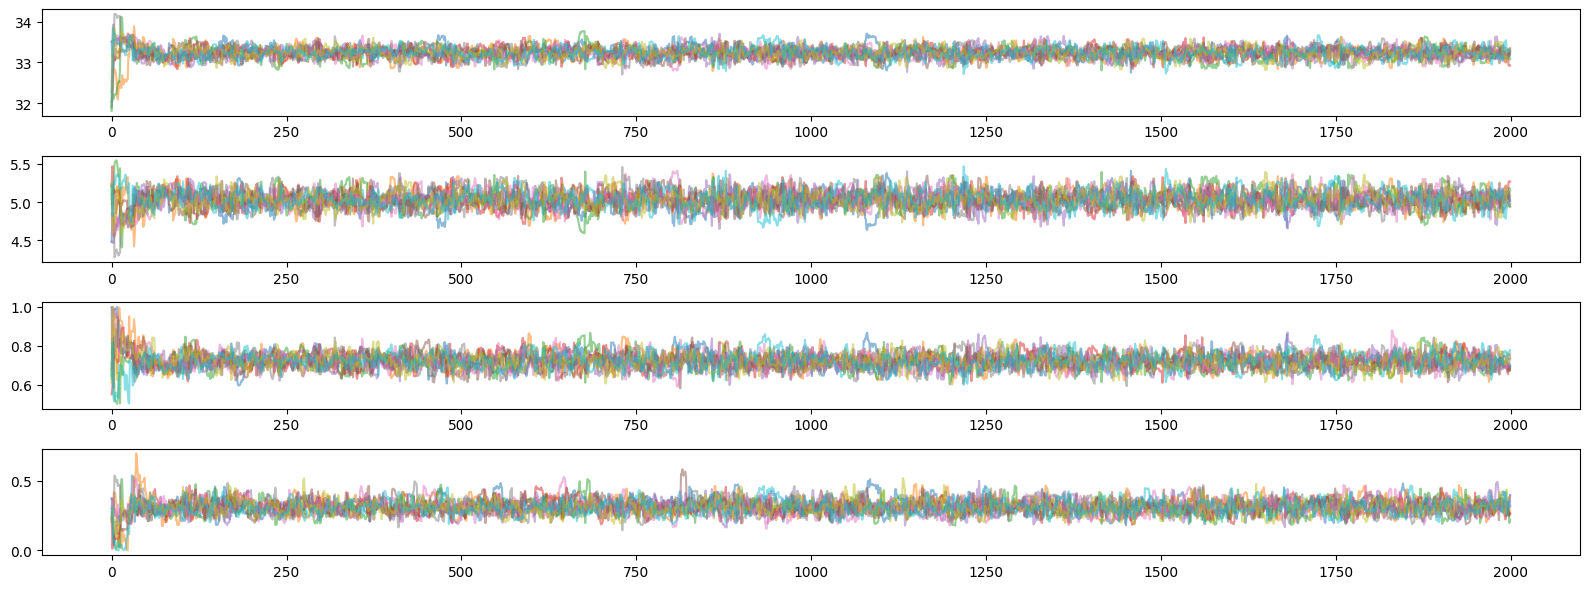

In [17]:
%matplotlib inline
path = dpath+'results/chain_test_Om.pdf'
plt.figure(figsize=(16,1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(sampler.get_chain()[:,:,n], alpha=0.5)
plt.tight_layout()
plt.savefig(path)
plt.show()

In [18]:
# flatten the chains, thin them by a factor of 1, and remove the burn-in (first 25% of the chain)
chain = sampler.get_chain(flat=True, discard=nsteps//4, thin=1)

Graficando los posteriores

Removed no burn in


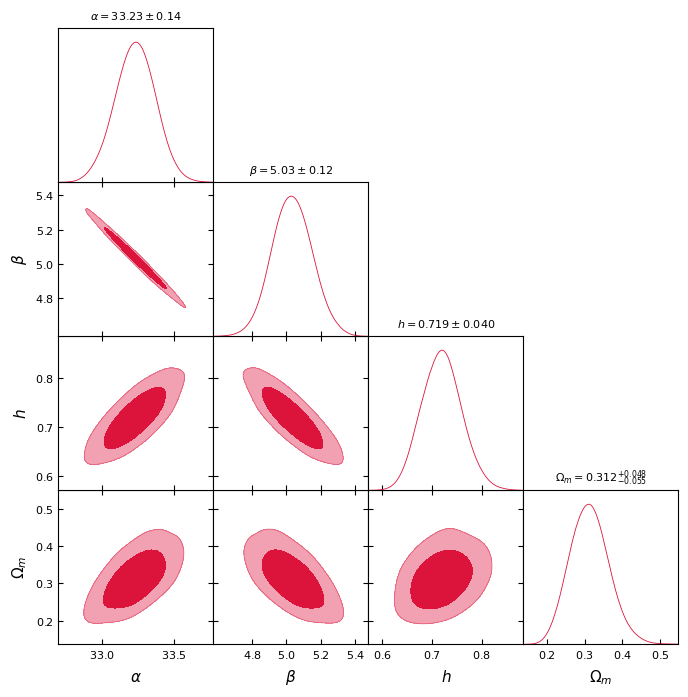

In [19]:
%matplotlib inline
tag = 'GDplot'
path = dpath+'results/GDplotOm.pdf'
GDsamples = MCSamples(samples=chain, names=parameters,
                          labels=parameters, name_tag=tag
                        , ranges={r"\Omega_m":[0.0, None]}
                          )

g = plots.getSubplotPlotter() #width_inch=4
g.settings.num_plot_contours = 2
g.triangle_plot(GDsamples, filled=True, title_limit=1,
            contour_colors=['crimson']
            # , param_limits={r"\alpha":[32.8, 33.7]
                        # , r"\beta":[4.7, 5.35]
                        # , r"h":[0.6, 0.85]
                        # , r"\Omega_m":[0.0, 0.52]
                        # , r"w_0":[-2.1, -0.2]
                        # }
            )
g.export(path)